# Questionnaire Short Answer Text Analysis

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [ ]:
import re
from word2number import w2n

## Read Data

In [2]:
mgpggdf = pd.read_csv('/Users/aaronberman/Desktop/DA_4_MGPGG/src/zBigData/mgpgg_df_all_sessions.csv')

/var/folders/ry/bf84d3cd54jctn_cwy_5666m0000gn/T/ipykernel_15462/463833470.py:1: DtypeWarning: Columns (215,216) have mixed types. Specify dtype option on import or set low_memory=False.
  mgpggdf = pd.read_csv('/Users/aaronberman/Desktop/DA_4_MGPGG/src/zBigData/mgpgg_df_all_sessions.csv')


## Basic Stats

In [3]:
print(mgpggdf['player.time_spent_survey_one'].mean())

174.21121650536855


## Preprocessing 

In [4]:
filtered_df = mgpggdf[mgpggdf['subsession.round_number'] == 1]

compare_groups_responses = [x for x in filtered_df['player.compare_groups'].tolist() if pd.notna(x)]
reasoning_responses = [x for x in filtered_df['player.reasoning'].tolist() if pd.notna(x)]
signaling_responses = [x for x in filtered_df['player.signaling'].tolist() if pd.notna(x)]


In [16]:
compare_groups_responses
reasoning_responses
signaling_responses

["I saw that more people were investing more in the green group, so I put more of my investments into that group. I'm unsure if it worked, but that was how I thought about investing my points. ",
 "At first I didn't invest much because I naturally though people would just be greedy, then it looked like everybody started putting points in and eventually we were all putting 10 at a time. The green group was going up so I started to put 10 in, but the Blue wasn't moving so i kept all ",
 'I do not have a preference in which groups i invested in to be completely honest',
 'I knew that investing 0 guaranteed me to keep 20 or more points every time so I played it safe. ',
 'first experiment blue was investing a lot so i went all in but green wasnt so i didnt',
 'At first I was trying to evaluate the total amount that was going to be invested by both groups. On the Blue group there was general concensus that everyone was investing their 10 pints. On the green group nobody was investing until 

In [ ]:
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Replace numbers with their word equivalents
    def replace_with_words(match):
        number = match.group(0)
        try:
            return w2n.word_to_num(number)
        except:
            return number
        
    text = re.sub(r'\b\d+\b', replace_with_words, text)
    
    # Removing punctuation (you might need to expand this list for other punctuations)
    text = re.sub(r'[^\w\s]', '', text)
    
    return text

# Apply the preprocessing to a list of survey responses
def preprocess_responses(responses):
    return [preprocess_text(response) for response in responses]

# Test
sample_responses = [
    "Hello, I have 4 apples and 20 oranges!",
    "I bought 15 candies."
]
preprocessed_responses = preprocess_responses(sample_responses)
print(preprocessed_responses)


## K-means Clustering

In [ ]:
compare_groups_responses
reasoning_responses
signaling_responses

In [9]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.85)
X = vectorizer.fit_transform(compare_groups_responses)

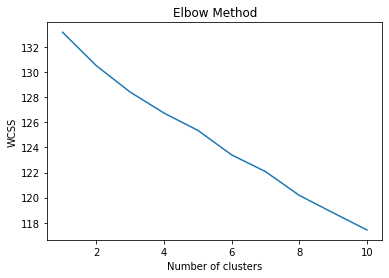

In [11]:
# Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plotting the results
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [12]:
optimal_clusters = 6  # Change this based on your Elbow plot
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
predicted_clusters = kmeans.fit_predict(X)


In [13]:
df = pd.DataFrame(compare_groups_responses, columns=['Response'])
df['Cluster'] = predicted_clusters

# Viewing responses per cluster
for i in range(optimal_clusters):
    print(f"Cluster {i}:")
    print(df[df['Cluster'] == i]['Response'])
    print("\n")


Cluster 0:
3      I knew that investing 0 guaranteed me to keep ...
12     I personally tried my best to invest as much a...
17     I just experimented and saw which one I got mo...
24     Honestly I just decided to risk it and see wha...
27     I typically invested equally into both groups ...
29     I invested more because if others were also go...
31     I honestly just kept the same for both. They w...
37     To be honest I did not really think much about...
38     I realized that the less I invested, the more ...
41     My investments were rather consistent after th...
48     I chose to put in 1/2 my points into the group...
52     Depending on the amounts I saw earned me more ...
59     I paid attention to the trends I was seeing wi...
67     Basing it off prior investments and seeing how...
75     I am not very good at math but I wanted to kee...
78     If others  were tending to not invest as much,...
85     I wanted to not invest that much because I tho...
99     I mostly spli

In [ ]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(optimal_clusters):
    print(f"Cluster {i}:")
    for ind in order_centroids[i, :10]:  # Top 10 terms per cluster
        print(terms[ind])
    print("\n")


### Keyword Analysis

In [ ]:
from summarizer import KeywordSummarizer

def extract_keywords_bert(docs, n_keywords=5):
    model = KeywordSummarizer(model_name='bert-base-uncased')
    keywords = []
    for doc in docs:
        key = model.extract_keywords(doc, key_count=n_keywords)
        keywords.append([k[0] for k in key])
    return keywords
